Importing standard python dependencies

In [21]:
import os, requests, zipfile
import numpy as np
import pandas as pd

Data Strategy

We use requests and zipfile modules to retrieve and extract the data on climate change from World Bank API.

Two separate functions are defined for downloading and extracting data respectively. A joinery function is then defined for the two prior functions

In [22]:
# Define the remote file to retrieve the world bank data on climate change
climate_data_url = "https://api.worldbank.org/v2/en/topic/19?downloadformat=csv"

# The base path for all the files
base_path = os.getcwd()
# The path for storing the zip file for climate change data
storage_path = f"{base_path}/climate_data.tar.gz"

In [23]:
def get_data(url):
  if not os.path.exists(storage_path):
    df = requests.get(url)
    with open(storage_path, 'wb')as file:
      file.write(df.content)

def extract_file(f_path):
  if not os.path.exists("API_19_DS2_en_csv_v2_4028487.csv"):
    with zipfile.ZipFile(f_path, "r") as zp:
      zp.extractall(base_path)

def prepare_data(url, f_path):
  get_data(url)
  extract_file(f_path)

prepare_data(climate_data_url, storage_path)

Data Manipulation

Pandas is a library for manipulating structured data for instance, series and dataframes. 

We use it in this case to convert the csv data to a dataframe

In [24]:
climate_dataframe = pd.read_csv("API_19_DS2_en_csv_v2_4028487.csv", skiprows=4).drop(['Unnamed: 66'], axis=1)

# A function for scaling down large elements in a dataframe
def norm(df):
  maximum = np.max(df)
  norm = df/maximum
  return  norm

INFANT MORTALITY RATE


The infant mortality rate per every 1000 births of the countries and regions in the world

In [25]:
MRT_dataframe = climate_dataframe[climate_dataframe['Indicator Code'] == 'SH.DYN.MORT'].drop(['Indicator Name'], axis=1)
MRT_filtered = MRT_dataframe.fillna(0)
MRT_filtered.replace([np.inf, -np.inf], 0, inplace=True)

In [26]:
MRT_1990 = MRT_filtered['1990'].values
MRT_2019 = MRT_filtered['2019'].values
MRT_filtered.head(8)

,Country Name,Country Code,Indicator Code,1960,1961,1962,1963,1964,1965,1966,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
8,Aruba,ABW,SH.DYN.MORT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
84,Africa Eastern and Southern,AFE,SH.DYN.MORT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,78.250071,74.816673,71.794958,69.138157,66.515928,64.243994,62.072936,60.054150,58.158650,0.0
160,Afghanistan,AFG,SH.DYN.MORT,358.2,352.2,346.3,340.6,335.1,329.8,324.4,...,80.300000,76.900000,73.600000,70.400000,67.500000,64.800000,62.300000,60.100000,58.000000,0.0
236,Africa Western and Central,AFW,SH.DYN.MORT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,114.997108,112.191190,109.696287,107.291693,104.637694,102.032086,99.291140,96.494289,93.627023,0.0
312,Angola,AGO,SH.DYN.MORT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,105.100000,98.500000,92.900000,88.100000,84.100000,80.600000,77.300000,74.200000,71.500000,0.0
388,Albania,ALB,SH.DYN.MORT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,11.200000,10.400000,9.900000,9.600000,9.400000,9.400000,9.500000,9.700000,9.800000,0.0
464,Andorra,AND,SH.DYN.MORT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.000000,3.800000,3.500000,3.300000,3.200000,3.000000,2.800000,2.700000,2.500000,0.0
540,Arab World,ARB,SH.DYN.MORT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,41.367554,40.605938,39.658575,38.627307,37.681715,36.231374,35.615147,34.885759,34.086399,0.0


ACCESS TO ELECTRICITY

Percentage of population having access to electricity. For clustering, we are choosing 1990 and 2019 as our years of choice

In [27]:
elec_dataframe = climate_dataframe[climate_dataframe['Indicator Code'] == 'EG.ELC.ACCS.ZS'].fillna(0)
elect_1995_ds = elec_dataframe['1995'].values
elect_2019_ds = elec_dataframe['2010'].values

Mini-Batch K-Means

Mini-Batch K-Means is a modified version of k-means that makes updates to the cluster centroids using mini-batches of samples rather than the entire dataset, which can make it faster for large datasets, and perhaps more robust to statistical noise .

In [28]:
# importing dependencies
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
 
def change_shape(grpA, grpB):
  ds = np.empty((266, 2))
  for index, (n,m) in enumerate(zip(grpA, grpB)):
    ds[index, 0] = n
    ds[index, 1] = m
  return ds

In [29]:
# A function for finding KMeans clusters
def cluster_Batch_Means(data):
  model =  MiniBatchKMeans(n_clusters=10)
  data_pred = model.fit_predict(data)
  data_pred_unique = np.unique(data_pred)
  return data_pred, data_pred_unique

# A function for plotting clusters 
def plot_clusters(clusters,predicted, combined, title, xlabel, ylabel):
  fig = plt.figure()
  ax = fig.add_subplot(projection='polar')
  ax.set_title(title)
  for cluster in clusters:
    # get row indexes for samples with this cluster
    row_ix = np.where(predicted == cluster)
    # create scatter of these samples
    ax.scatter(combined[row_ix, 0], combined[row_ix, 1], cmap='hsv', alpha=0.75)
    
  # show the plot
  plt.show()

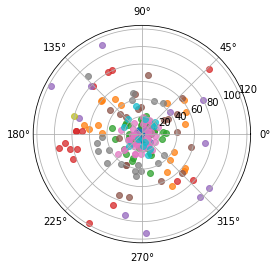

In [30]:
MRT_combined = change_shape(MRT_1990, MRT_2019)
MRT_combined_hat = cluster_Batch_Means(MRT_combined)[0]
MRT_combined_clusters = cluster_Batch_Means(MRT_combined)[1]
plot_clusters(
        MRT_combined_clusters, 
        MRT_combined_hat, 
        MRT_combined, 
        "", 
        "1990 Infant Mortality Rate", 
        "2015 Infant Mortality Rate")

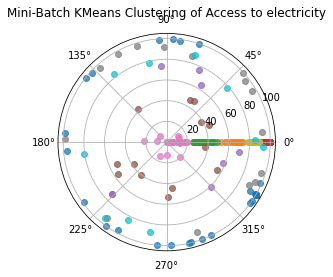

In [31]:
elec_1990_2019 = change_shape(elect_1995_ds, elect_2019_ds) # reshape and concatenate the two time series
elec_hat = cluster_Batch_Means(elec_1990_2019)[0]  # The predicted value 
elec_clusters = cluster_Batch_Means(elec_1990_2019)[1] # The clusters
# Visualize the population growth rate clusters
plot_clusters(
        elec_clusters, 
        elec_hat, 
        elec_1990_2019, 
        "Mini-Batch KMeans Clustering of Access to electricity", 
        "1990 Access to electricity", 
        "2019 Access to electricity")

Gaussian Mixture Model

A Gaussian mixture model summarizes a multivariate probability density function with a mixture of Gaussian probability distributions as its name suggests.

In [34]:
from sklearn.mixture import GaussianMixture

def cluster_GauMix(data):
  model =  GaussianMixture(n_components=10)
  data_pred = model.fit_predict(data)
  data_pred_unique = np.unique(data_pred)
  return data_pred, data_pred_unique

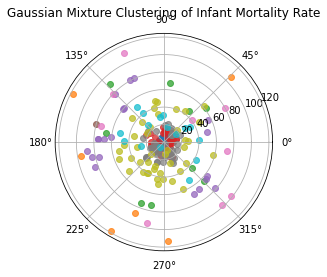

In [35]:
MRT_combined = change_shape(MRT_1990, MRT_2019)
MRT_combined_hat = cluster_GauMix(MRT_combined)[0]
MRT_combined_clusters = cluster_GauMix(MRT_combined)[1]
plot_clusters(
        MRT_combined_clusters, 
        MRT_combined_hat, 
        MRT_combined, 
        "Gaussian Mixture Clustering of Infant Mortality Rate", 
        "1990 Infant Mortality Rate", 
        "2015 Infant Mortality Rate")

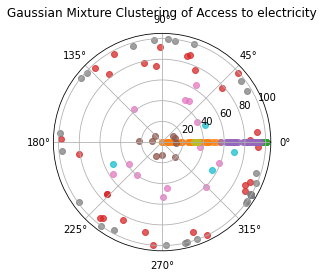

In [36]:
elec_1990_2019 = change_shape(elect_1995_ds, elect_2019_ds)
elec_hat =  cluster_GauMix(elec_1990_2019)[0]
elec_clusters =  cluster_GauMix(elec_1990_2019)[1]
# Visualize the population growth rate clusters
plot_clusters(
        elec_clusters, 
        elec_hat, 
        elec_1990_2019, 
        "Gaussian Mixture Clustering of Access to electricity", 
        "1990 Access to electricity", 
        "2019 Access to electricity")

Part II

Curve Fitting

Curve fitting is the way we model or represent a data spread by assigning a ‘best fit‘ function (curve) along the entire range. Ideally, it will capture the trend in the data and allow us to make predictions of how the data series will behave in the future

/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


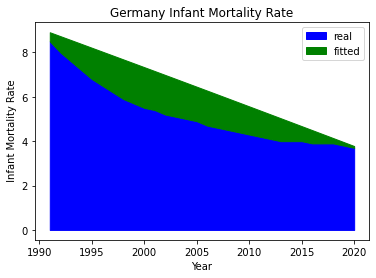

In [37]:
from scipy.optimize import curve_fit

# PREPARING THE TIME SERIES DATA ON INFANT MORTALITY RATE
DEU_MRT = MRT_filtered[MRT_filtered['Country Name'] == 'Germany'].drop(['Country Name', 'Country Code'], axis=1).values[0][1:61].astype('float')
BRA_MRT = MRT_filtered[MRT_filtered['Country Name'] == 'Brazil'].drop(['Country Name', 'Country Code'], axis=1).values[0][1:61]
CHN_MRT = MRT_filtered[MRT_filtered['Country Name'] == 'China'].drop(['Country Name', 'Country Code'], axis=1).values[0][1:61]

years = np.arange(1961,2021,1)
years_10 = np.arange(2022,2033, 1)

# Define an objective function for population growth rate of Germany
def objective_DEU(x, a, b, c, d, e):
	return a*x**3 - b*x**d + x*e

# Define an objective function for population growth rate of BRAZIL
def objective_BRA(x,a,b):
  return a*x + b

# A function for calculating the error between the real and predicted value
def get_loss(y, ypred):
  return y-ypred

# fitting to find the best curve for Germany Population Growth
def fit_DEU(x, y):
  popt, _ = curve_fit(objective_DEU, years, DEU_MRT)
  a, b, c, d, e= popt
  y_fitted = objective_DEU(years, a, b, c, d, e)
  return y_fitted

# fitting to find the best curve for Brazil Population Growth Rate
def fit_BRA(x, y):
  popt, _ = curve_fit(objective_BRA, years, BRA_MRT)
  a, b = popt
  y_fitted = objective_BRA(years, a, b)
  return y_fitted

# fitted population growth rate for Germany
DEU_MRT_fitted = fit_DEU(years, DEU_MRT)
# fitted population growth rate for Brazil
BRA_MRT_fitted = fit_BRA(years, BRA_MRT)

 
def plot_area(
        x, 
        y, 
        yhat, 
        title, 
        xlabel, 
        ylabel, label1="real", label2="fitted", label3="loss"):
  fig,ax = plt.subplots()
  ax.set_title(title)
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)
  ax.fill_between(x,y,0, color='b', label=label1)
  ax.fill_between(x, yhat,y, color='g', label=label2)
  plt.legend()
  plt.show()
  
# An area plot of the two time series for the last 30 years
plot_area(
    years[-30:], 
    DEU_MRT[-30:], 
    DEU_MRT_fitted[-30:], 
    "Germany Infant Mortality Rate", 
    "Year", 
    " Infant Mortality Rate")

ERROR RANGES FOR GERMANY INFANT MORTALITY RATE

We choose Germany for the sake of brevity

In [40]:
def plot_limits(x,y,lower,upper,title,xlabel,ylabel,label1="actual",label2="lower",label3="upper"):
  fig,ax = plt.subplots()
  ax.set_title(title)
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)
  ax.fill_between(x,y,lower,color="g",label=label1)
  ax.fill_between(x, lower,0,color="r", label=label2)
  ax.fill_between(x, upper,y, color="b", label=label3)
  plt.legend()
  plt.show()

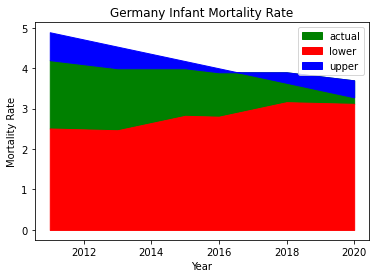

In [41]:

sigma_DEU = get_loss(DEU_MRT[-10:], DEU_MRT_fitted[-10:]) # losses
limit_offset = 0.5
# Lower and Upper limits of Population Growth Rate of Germany
def error(x, func, param, sigma):
    import itertools as iter
    lower = func(x, *param)
    upper = lower    
    uplow = []
    for p,s in zip(param, sigma):
        pmin = p - s
        pmax = p + s
        uplow.append((pmin, pmax))
        
    pmix = list(iter.product(*uplow))
    
    for p in pmix:
        y = func(x, *p)
        lower = np.minimum(lower, y)
        upper = np.maximum(upper, y)

    plot_limits(
            years[-10:], 
            param, 
            lower, upper, 
            "Error Rate for Germany Infant Mortality Rate", 
            "Year", "Mortality Rate" )    
    return lower, upper

def func(x, *args):
  lower = []
  for y in args:
    lower.append(y-x)
  return lower

 
lower_DEU, upper_DEU = err_ranges(limit_offset, func, DEU_MRT[-10:], sigma_DEU)